In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.branch_definer as branch_definer
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
samples_per_class = 500

letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

classes = np.unique(dataset.targets)
# classes = [letter_to_class[l] for l in ("A", "V", "Y")]
inputs_by_class = {}
for c in classes:
    mask = dataset.targets == c
    inputs = dataset.data[mask]
    sample_inds = torch.tensor(np.random.choice(len(inputs), size=samples_per_class, replace=False))
    inputs_by_class[c] = torch.tensor(inputs[sample_inds]).to(DEVICE)
input_shape = (16,)

In [4]:
# Create the diffuser
diffuser = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

### Plotting functions

In [5]:
def plot_forward_diffusion(diffused_inputs_by_class, times):
    """
    Plots the trajectory of the forward-diffusion process.
    Arguments:
        `diffused_inputs_by_class`: the output of
            `branch_definer.run_forward_diffusion`
        `times`: array of times that diffusion was performed at
    """
    # Show distribution over time
    fig, ax = plt.subplots(figsize=(20, 8))
    bins = np.linspace(-4, 4, 1000)
    cmap = plt.get_cmap("magma")
    for t_i in tqdm.notebook.trange(len(times)):
        all_vals = np.concatenate([
            np.random.choice(np.ravel(x[t_i].cpu().numpy()), size=100, replace=False)
            for x in diffused_inputs_by_class.values()
        ])
        ax.hist(all_vals, bins=bins, histtype="step", color=cmap(t_i / len(times)), alpha=0.5, density=True)
    batch_size = next(iter(diffused_inputs_by_class.values())).shape[0]
    prior = diffuser.sample_prior(batch_size, torch.ones(batch_size).to(DEVICE) * times[-1]).cpu().numpy()
    ax.hist(np.ravel(prior), bins=bins, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")
    ax.set_title("Evolution of p(x) over forward SDE")
    ax.set_ylim((0, 3))
    plt.legend()
    plt.show()

In [6]:
def plot_similarities(sim_matrix, classes):
    """
    Plots the similarities between classes.
    Arguments:
        `sim_matrix`: a T x C x C similarity matrix between classes
            at various time points, output by
            `branch_definer.compute_time_similarities`
        `classes`: list of classes matching the order in `sim_matrix`
    """
    # Plot initial pairwise similarities
    labels = np.array(["%s-%s" % (classes[i], classes[j]) for i in range(len(classes)) for j in range(i + 1)])
    sims = np.array([sim_matrix[0, i, j] for i in range(len(classes)) for j in range(i + 1)])
    inds = np.flip(np.argsort(sims))
    labels, sims = labels[inds], sims[inds]
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.bar(labels, sims)
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity between pairs of classes (t = 0)")
    plt.show()
                
    # Plot average similarity over time
    mean_sims = []
    triu_inds = np.triu_indices(len(classes))
    for t_i in range(len(sim_matrix)):
        mean_sims.append(np.mean(sim_matrix[t_i][triu_inds]))
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(mean_sims)
    ax.set_xlabel("t")
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity over all classes during forward diffusion")
    plt.show()

### Compute branch definitions

Forward-diffusing class 0
Forward-diffusing class 1
Forward-diffusing class 2
Forward-diffusing class 3
Forward-diffusing class 4
Forward-diffusing class 5
Forward-diffusing class 6
Forward-diffusing class 7
Forward-diffusing class 8
Forward-diffusing class 9
Forward-diffusing class 10
Forward-diffusing class 11
Forward-diffusing class 12
Forward-diffusing class 13
Forward-diffusing class 14
Forward-diffusing class 15
Forward-diffusing class 16
Forward-diffusing class 17
Forward-diffusing class 18
Forward-diffusing class 19
Forward-diffusing class 20
Forward-diffusing class 21
Forward-diffusing class 22
Forward-diffusing class 23
Forward-diffusing class 24
Forward-diffusing class 25


  0%|          | 0/1000 [00:00<?, ?it/s]

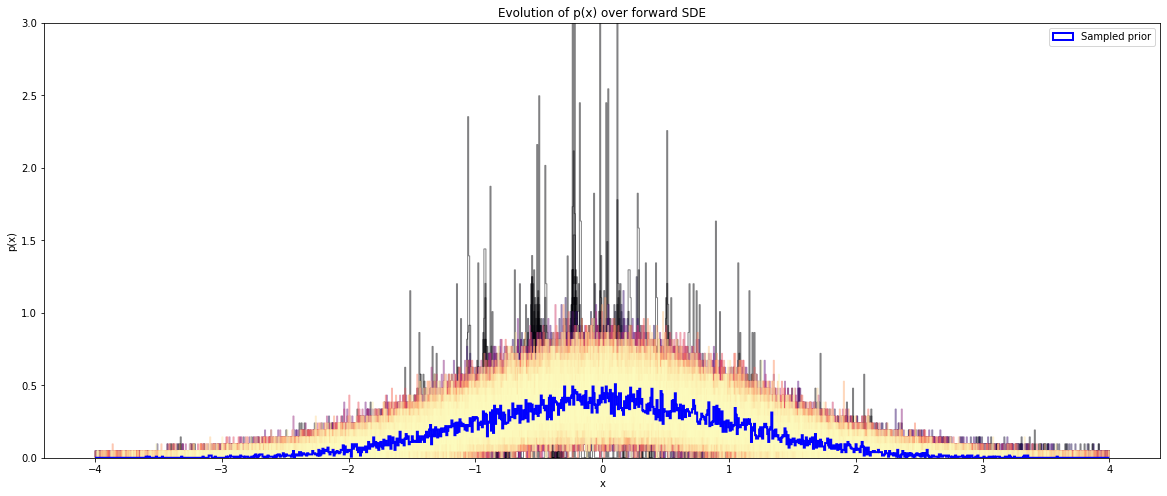

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.67it/s]


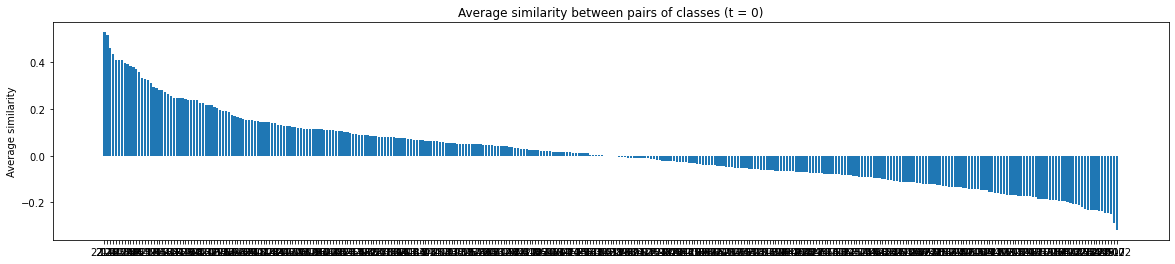

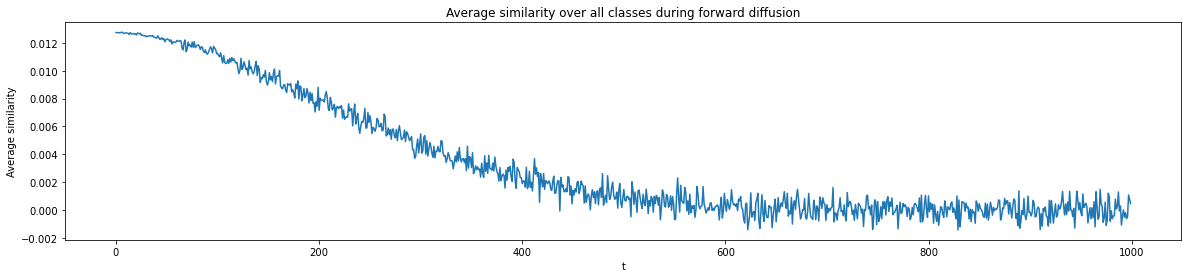

[(0.15615615615615616, (18,), (23,)), (0.25725725725725723, (6,), (14,)), (0.26426426426426425, (6, 14), (7,)), (0.27627627627627627, (18, 23), (1,)), (0.32232232232232233, (1, 18, 23), (25,)), (0.34134134134134136, (6, 7, 14), (16,)), (0.35135135135135137, (17,), (1, 18, 23, 25)), (0.3533533533533533, (24,), (19,)), (0.3563563563563564, (4,), (2,)), (0.36036036036036034, (19, 24), (5,)), (0.3733733733733734, (1, 17, 18, 23, 25), (6, 7, 14, 16)), (0.3813813813813814, (10,), (1, 6, 7, 14, 16, 17, 18, 23, 25)), (0.3863863863863864, (3,), (1, 6, 7, 10, 14, 16, 17, 18, 23, 25)), (0.4024024024024024, (21,), (5, 19, 24)), (0.4094094094094094, (1, 3, 6, 7, 10, 14, 16, 17, 18, 23, 25), (13,)), (0.4134134134134134, (2, 4), (1, 3, 6, 7, 10, 13, 14, 16, 17, 18, 23, 25)), (0.4174174174174174, (20,), (1, 2, 3, 4, 6, 7, 10, 13, 14, 16, 17, 18, 23, 25)), (0.4364364364364364, (15,), (5, 19, 21, 24)), (0.45645645645645644, (1, 2, 3, 4, 6, 7, 10, 13, 14, 16, 17, 18, 20, 23, 25), (12,)), (0.4724724724724

In [7]:
times = np.linspace(0, t_limit, 1000)
diffused_inputs_by_class = branch_definer.run_forward_diffusion(
    inputs_by_class, diffuser, times
)
plot_forward_diffusion(diffused_inputs_by_class, times)
sim_matrix, sim_matrix_classes = branch_definer.compute_time_similarities(diffused_inputs_by_class, times)
plot_similarities(sim_matrix, sim_matrix_classes)
branch_points = branch_definer.compute_branch_points(sim_matrix, times, sim_matrix_classes, epsilon=1e-2)
branch_defs = branch_definer.branch_points_to_branch_defs(branch_points, t_limit)
print(branch_points)
print()
print([(tuple(class_to_letter[c] for c in trip[0]), trip[1], trip[2]) for trip in branch_defs])